In [1]:
#Load data manipulation packages
library(tidyverse)
library(ggplot2)

#Load time series library
library(forecast)
library(tseries)
library(TSA)

#Library to detrend data using ols
library(pracma)
library(SpecsVerification)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.5     
✔ tidyr   0.8.1          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘TSA’

The following object is masked from ‘package:readr’:

    spec

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar


Attaching package: ‘pracma’

The following object is masked from ‘package:purrr’:

    cross



In [2]:
#Function to adjust plot dimensions
set_plot_dimensions = function(width_choice=12, height_choice=6) {
    
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
    
        }

In [3]:
#Read data in
dat = read.csv('bike_sharing_hourly.csv')

In [4]:
#Convert date column from type string to type date
dat[,'dteday'] = as.Date(dat[,'dteday'])

In [5]:
#Create train and test splits
train = dat[dat[,'dteday'] >= '2011-01-01' & dat[,'dteday'] < '2012-10-31', ]
test = dat[dat[,'dteday'] >= '2012-11-01', ]

Bike ride counts are always $\geq$ 0. Furthermore we observe it variance changes with time. Thus we employ a power transformation to overcome these problems.

## Data Transformations

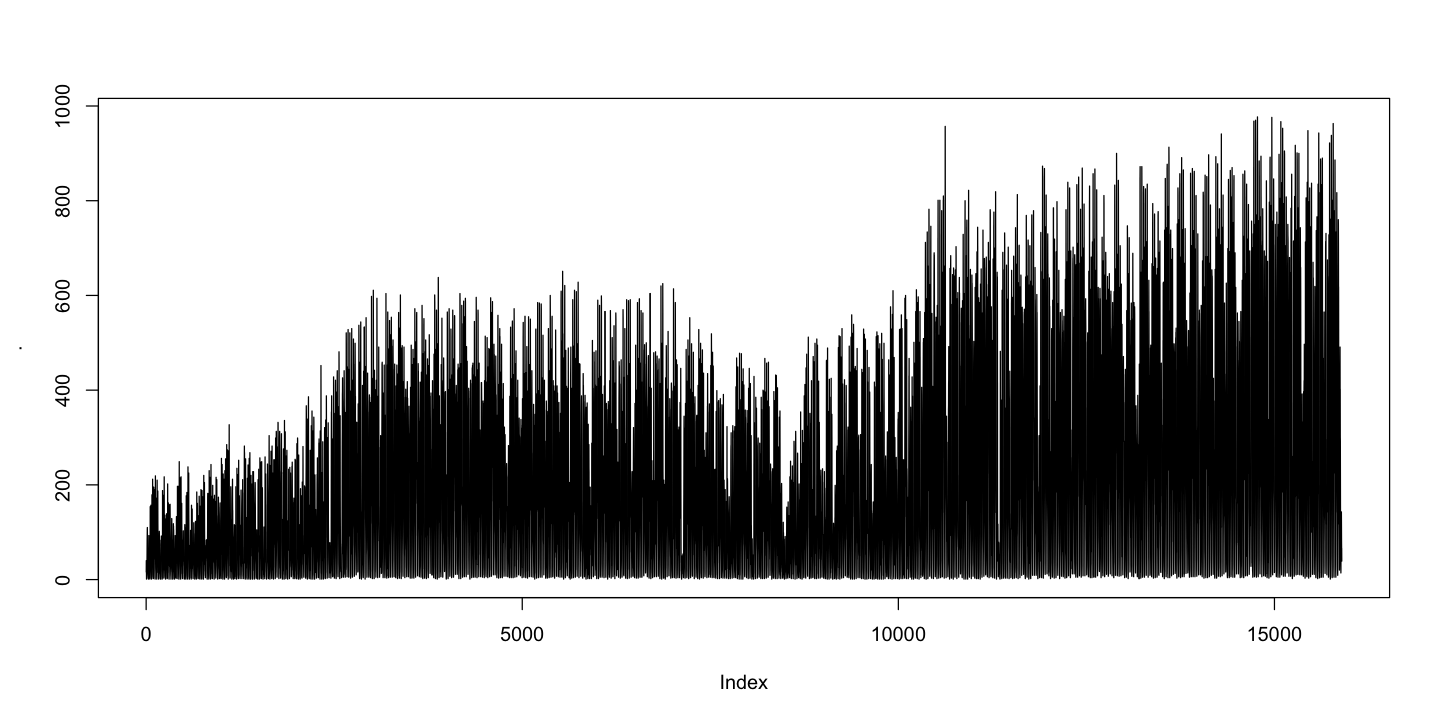

In [6]:
set_plot_dimensions()
train$cnt %>% plot(type='l')

If we adjust for seasonal effects we notice an almost quadratic like trend. We also observe that variability of the series seems to be increasing with time. This suggests that the trend and seasonal components interact in a multiplicative manner. A box cox transformation can be used to stabilize the variance and allow us to use an additive model. 

In [7]:
#Compute optimal box cox transformation to use to stabilize variance
lambda1 = BoxCox.lambda(train$cnt)

In [8]:
transformed_count = BoxCox(train$cnt, lambda = lambda1)

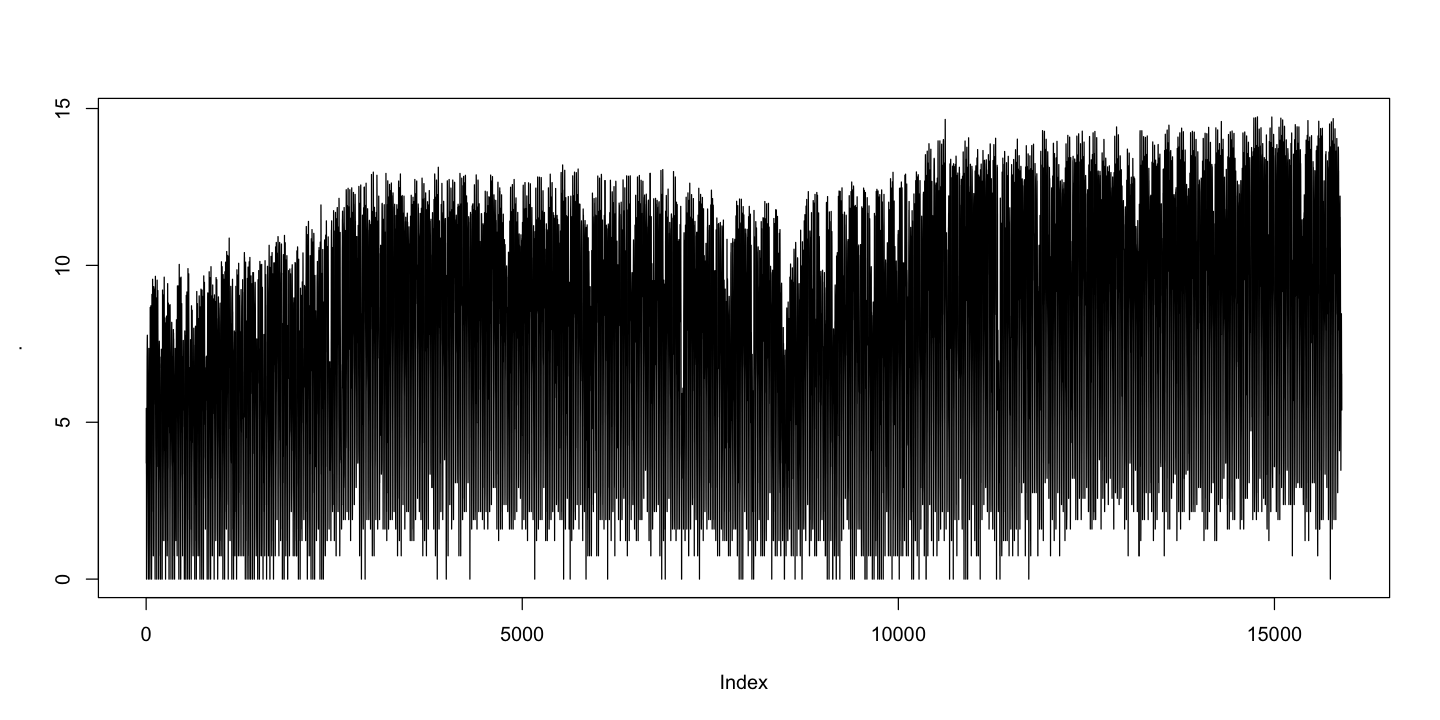

In [9]:
set_plot_dimensions()
transformed_count %>% plot(type='l')

Looks much better!

## Linear Regression with Fourier Terms

Building on from our previous analysis, we would like to decompose a time series. Thus we would like to model our time series as:

<center> $Y_{t} \hspace{0.1cm} = \text{Trend}_{t} \hspace{0.1cm} + \hspace{0.1cm} \text{Seasonal}_{t} \hspace{0.1cm} + \hspace{0.1cm} \text{Remainder}_{t}$ <center>

To capture the trend, we intend to use a polynomial (i.e. quadratic time trend)
To capture seasonality, we intend to use fourier terms. This is because:
1. Bike counts exhibit multiple seasonalities (i.e. daily, weekly and yearly).
2. Each of these seasonalities are of high frequency.

The remainder is what is left over not yet captured by the model. We intend to model it using ARMA.

We seek to build models of the form
<center> $Y_{t} \hspace{0.1cm} = \hspace{0.1cm} \beta_{0,t} \hspace{0.1cm} + \hspace{0.1cm} \beta_{1,t}X_{t} \hspace{0.1cm} + \hspace{0.1cm} \nu_{t}$
    
where $\nu_{t} \hspace{0.1cm} \sim \hspace{0.1cm} \text{ARMA(p,q)}$    

In [12]:
#Create an msts object, explicitly encoding multiple seasonalities
m_seasons = c(24, 24*7, 24*365)
msts_count = msts(transformed_count, seasonal.periods = m_seasons, ts.frequency = 24)

In [13]:
#Create fourier terms to model seasonality
n_pairs = c(1,1,1)
fourier_pairs = fourier(msts_count, K = n_pairs)

In [14]:
#Create regressors dataframe to use in model
t = seq(1, length(transformed_count))

dat = data.frame(count=transformed_count, t, t^2,
                 train$atemp,
                 train$windspeed,
                 train$hum,
                 fourier_pairs)

In [15]:
#Fit a linear regression model
ols_fit = lm(count ~ ., data = dat)

In [16]:
summary(ols_fit)


Call:
lm(formula = count ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3952 -1.6475  0.3094  1.8688  8.7523 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.491e+00  1.679e-01  26.741  < 2e-16 ***
t                1.148e-04  1.920e-05   5.977 2.31e-09 ***
t.2              1.561e-10  1.157e-09   0.135  0.89272    
train.atemp      1.064e+01  2.562e-01  41.533  < 2e-16 ***
train.windspeed  1.545e+00  1.856e-01   8.324  < 2e-16 ***
train.hum       -4.748e+00  1.205e-01 -39.413  < 2e-16 ***
S1.24           -2.630e-01  3.066e-02  -8.578  < 2e-16 ***
C1.24           -5.066e-01  3.060e-02 -16.555  < 2e-16 ***
S1.168           1.263e-01  3.047e-02   4.144 3.43e-05 ***
C1.168          -1.218e-01  3.065e-02  -3.975 7.08e-05 ***
S1.8760          9.558e-02  3.423e-02   2.792  0.00525 ** 
C1.8760          1.072e+00  6.068e-02  17.674  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual stan

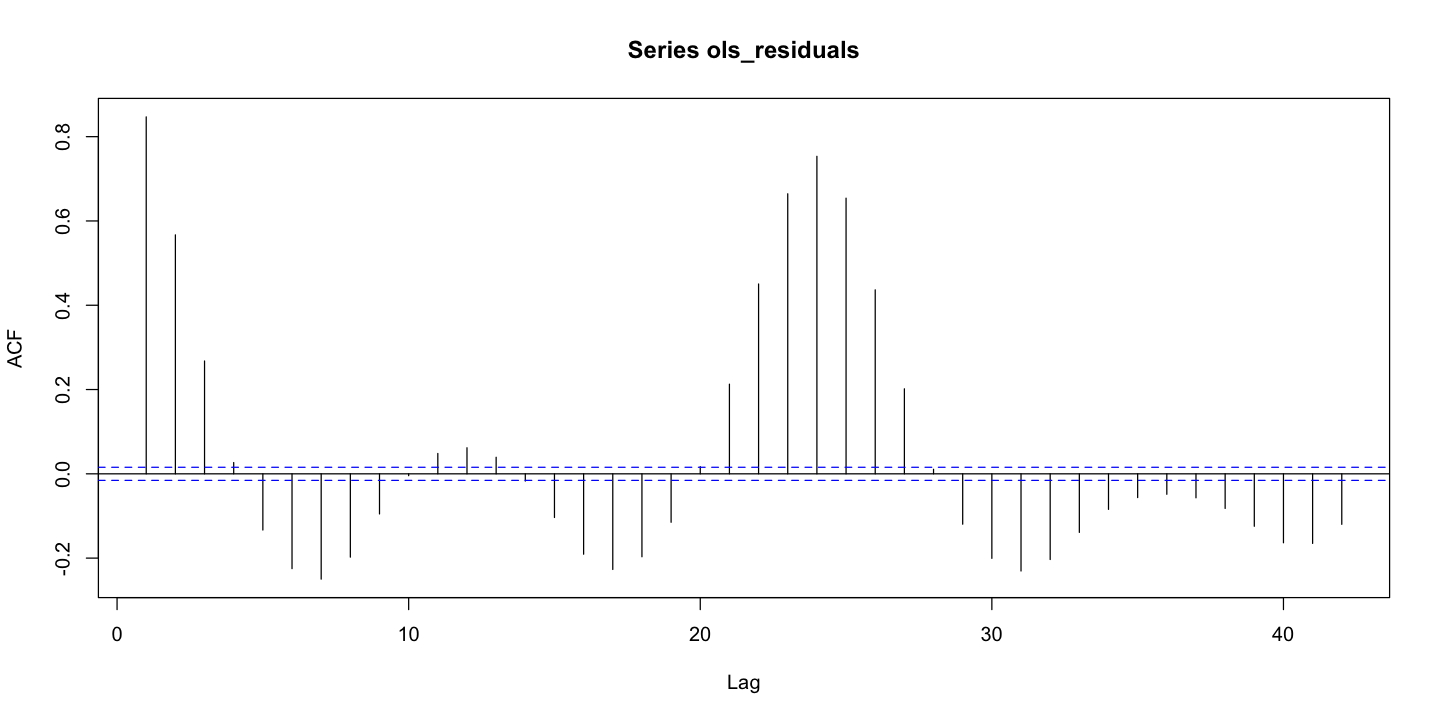

In [17]:
#Check residuals
set_plot_dimensions()
ols_residuals = residuals(ols_fit)
acf(ols_residuals)

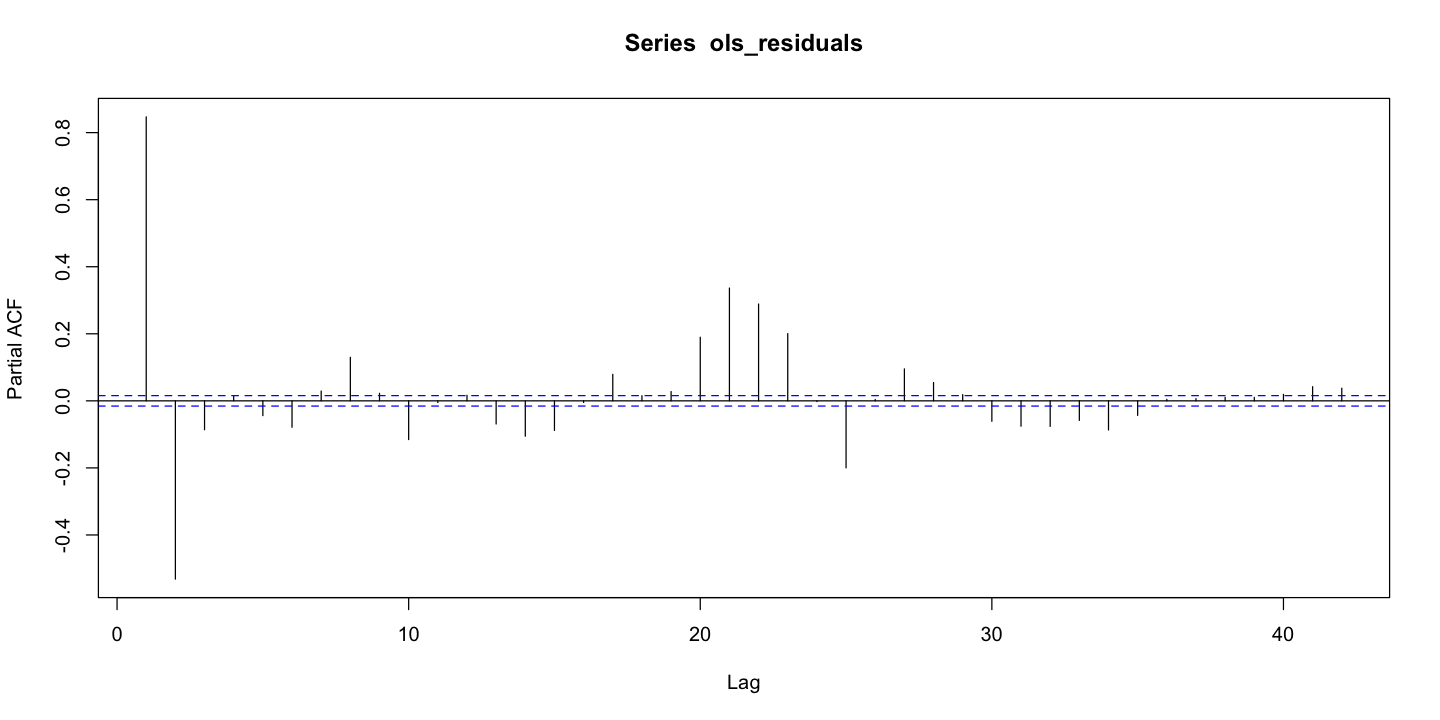

In [21]:
#Check PACF of residuals
pacf(ols_residuals)

In [18]:
#Model errrors using a SARIMA model
fit2 = auto.arima(ols_residuals, seasonal = TRUE)


	Ljung-Box test

data:  Residuals from ARIMA(3,0,1) with zero mean
Q* = 621.95, df = 6, p-value < 2.2e-16

Model df: 4.   Total lags used: 10



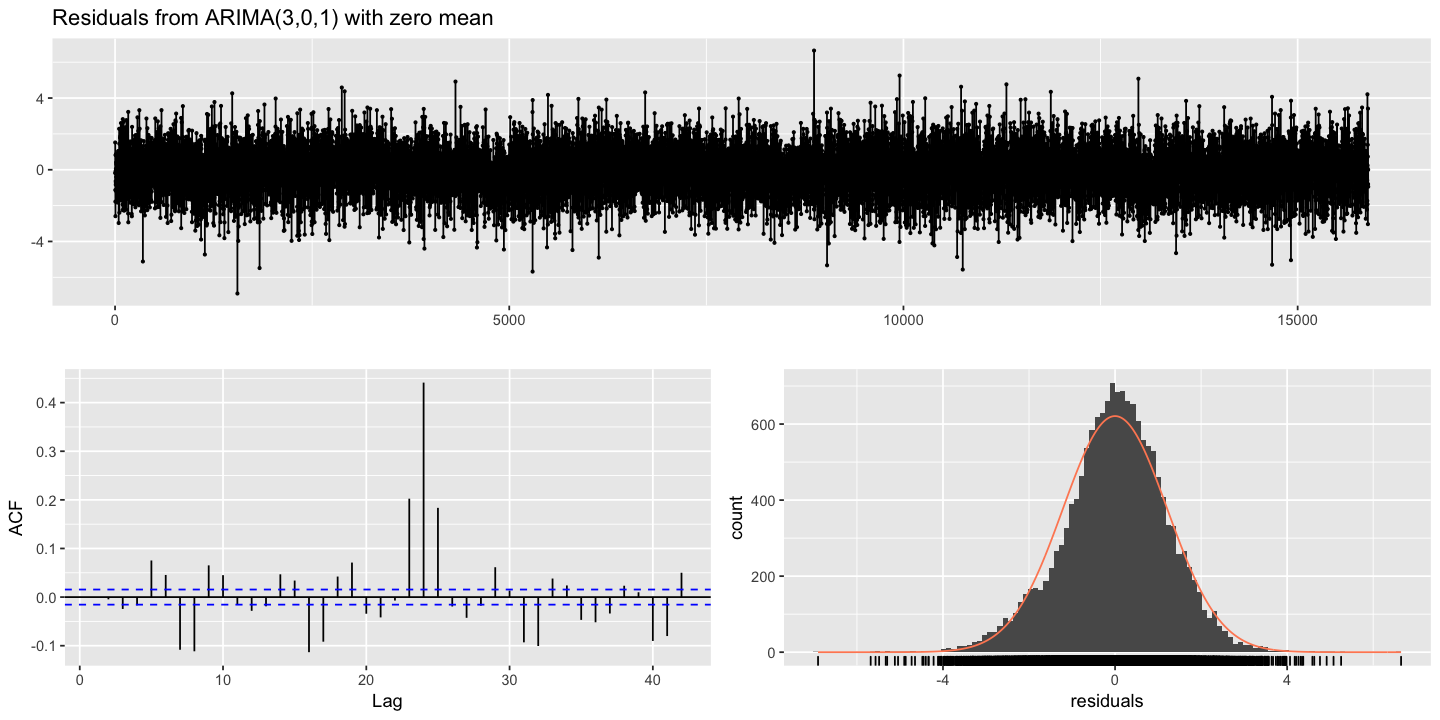

In [19]:
checkresiduals(fit2)

## Wrong WAY to do it!

In [22]:
#Create matrix of regressors
xreg = cbind(seasonality=fourier_pairs)

In [23]:
#Fit an ARIMA model
fit = auto.arima(msts_count, xreg = xreg, seasonal = FALSE)

In [24]:
summary(fit)

Series: msts_count 
Regression with ARIMA(2,1,3) errors 

Coefficients:
         ar1      ar2     ma1     ma2     ma3    S1-24    C1-24  S1-168
      0.2620  -0.6377  0.2957  0.7570  0.2686  -0.5380  -0.7610  0.1560
s.e.  0.0283   0.0201  0.0301  0.0097  0.0102   0.0892   0.0892  0.6241
       C1-168  S1-8760  C1-8760
      -0.0117  -0.2165  -1.5685
s.e.   0.6246  33.1756  32.1330

sigma^2 estimated as 1.523:  log likelihood=-25889.73
AIC=51803.47   AICc=51803.49   BIC=51895.55

Training set error measures:
                        ME     RMSE       MAE MPE MAPE      MASE        ACF1
Training set -6.000597e-05 1.233566 0.9477822 NaN  Inf 0.7835054 0.003563849


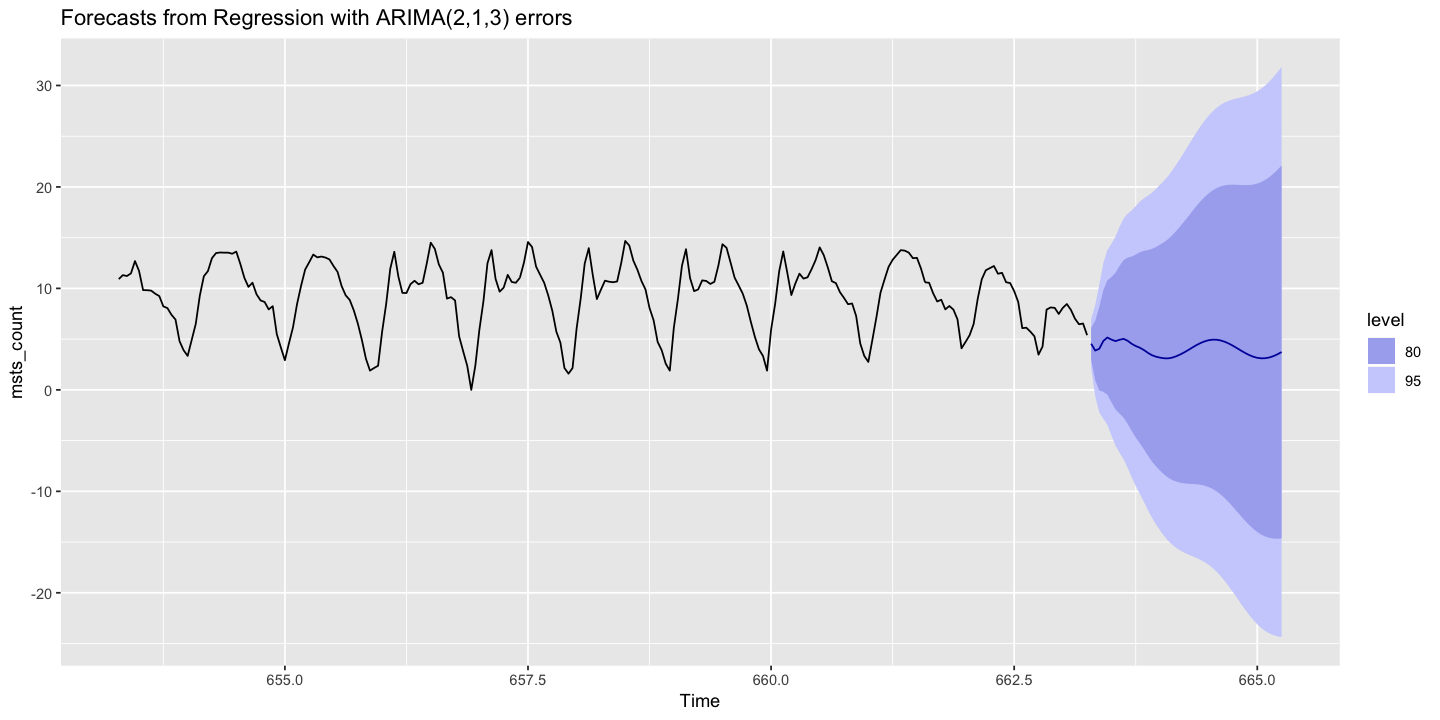

In [25]:
#Plot fitted values
fit %>%
  forecast(xreg=fourier(msts_count, K=n_pairs, h=24*2)) %>%
  autoplot(include=24*10)


	Ljung-Box test

data:  Residuals from Regression with ARIMA(2,1,3) errors
Q* = 9276.3, df = 37, p-value < 2.2e-16

Model df: 11.   Total lags used: 48



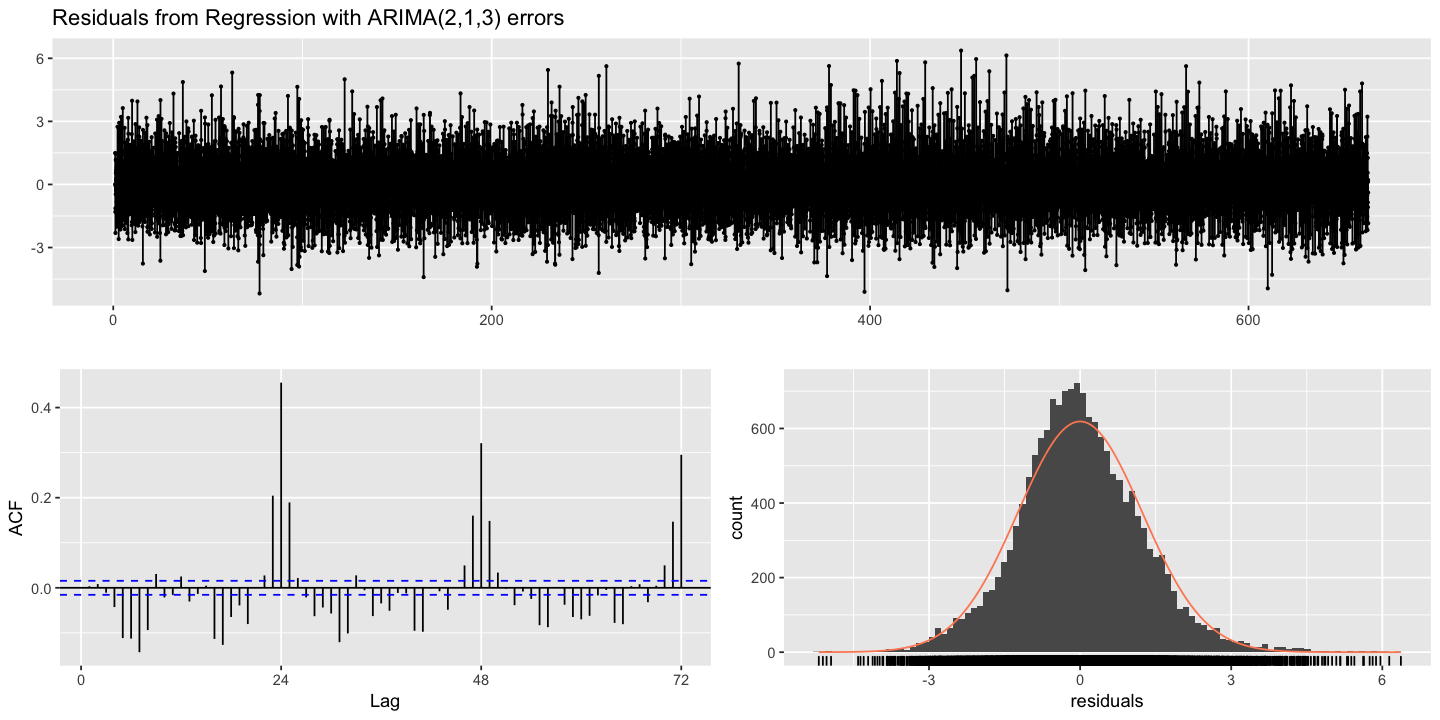

In [26]:
#Check residuals of fitted values
checkresiduals(fit)